In [5]:
import ast
import json
import mlflow
import os
import sys
import numpy as np

sys.path.append(os.path.dirname(os.getcwd()))
from constants import TRACKING_SERVER_URI, EXPERIMENT_PREFIX, DATA_DIR

mlflow.set_tracking_uri(TRACKING_SERVER_URI)

In [19]:
os.environ["MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR"] = "False"

In [2]:
ROUND_DECIMALS = 5

In [3]:
RESULTS_PATH = "/home/basbenja/Facultad/TrabajoFinal/results"
COMPARISON = "ML"

In [4]:
with open("../config.json", "r") as f:
    config = json.load(f)

GROUP = "Grupo" + str(config['group'])
print(GROUP)

GROUP_RESULTS_PATH = os.path.join(RESULTS_PATH, GROUP)
if not os.path.exists(GROUP_RESULTS_PATH):
    os.makedirs(GROUP_RESULTS_PATH)
    print(f"{GROUP_RESULTS_PATH} successfully created")
else:
    print(f"{GROUP_RESULTS_PATH} exists")


Grupo5
/home/basbenja/Facultad/TrabajoFinal/results/Grupo5 exists


In [ ]:
GROUP_DIR = os.path.join(DATA_DIR, GROUP)
GROUP_PARAMS_FILE = os.path.join(GROUP_DIR, f"params_{GROUP}.json")
if os.path.exists(GROUP_PARAMS_FILE):
    with open(GROUP_PARAMS_FILE, 'r') as f:
        group_params = json.load(f)
else:
    print(f"Group params file not found: {GROUP_PARAMS_FILE}")

REQ_PERIODS = group_params['first_tr_period'] - 1
N_PER_DEP = group_params['n_per_dep']
TR_STARTS = list(range(REQ_PERIODS, REQ_PERIODS + 3))

print(f"Períodos observados:     {REQ_PERIODS}")
print(f"Períodos de dependencia: {N_PER_DEP}")
print(f"Inicios de programa {TR_STARTS}")

Períodos observados:     45
Períodos de dependencia: 5
Inicios de programa [45, 46, 47]


In [15]:
MODEL_ARCHS = ["lstm_v2", "conv", "lstm_conv", "psm"]

EXPERIMENT_NAME = f"{EXPERIMENT_PREFIX}-{GROUP}-Comp{COMPARISON}"
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
experiment_id = experiment.experiment_id

print(f"{EXPERIMENT_NAME} - ID {experiment_id}")

TF-Grupo5-CompML - ID 948068830670406011


## **Listas de F1, precisión y recall por arquitectura**

In [ ]:
metrics_lists = {}

for model_arch in MODEL_ARCHS:
    print(f"Getting results for {model_arch}")
    runs = mlflow.search_runs(
        experiment_ids=[experiment_id],
        output_format="list",
        filter_string=f"params.model_arch = '{model_arch}'",
    )

    if len(runs) != 100:
        print(f"{model_arch} doesn't have 100 runs for experiment {EXPERIMENT_NAME}")

    precisions, recalls, f1s = [], [], []

    for run in runs:
        run_data = run.data
        run_params = run_data.params

        precisions.append(float(run_params['cohort_avg_precision']))
        recalls.append(float(run_params['cohort_avg_recall']))
        f1s.append(float(run_params['cohorts_avg_f1']))

        metrics_lists[model_arch] = {
            "precisions": precisions,
            "recalls": recalls,
            "f1s": f1s
        }

dst_path = os.path.join(GROUP_RESULTS_PATH, 'metrics_lists.json')
with open(dst_path, 'w') as f:
    json.dump(metrics_lists, f, indent=4, ensure_ascii=False)

## **Promedio y desviación estándar de las métricas por arquitectura**

In [ ]:
METRICS_LISTS_PATH = os.path.join(GROUP_RESULTS_PATH, 'metrics_lists.json')
with open(METRICS_LISTS_PATH, 'r') as f:
    metrics_lists = json.load(f)

In [ ]:
model_arch_results = {}

for model_arch, results in metrics_lists.items():
    precisions = np.array(results["precisions"])
    recalls    = np.array(results["recalls"])
    f1s        = np.array(results["f1s"])

    avg_precision = float(round(np.mean(precisions), ROUND_DECIMALS))
    avg_recall    = float(round(np.mean(recalls), ROUND_DECIMALS))
    avg_f1        = float(round(np.mean(f1s), ROUND_DECIMALS))

    precision_std = float(round(np.std(precisions, ddof=1), ROUND_DECIMALS))
    recall_std    = float(round(np.std(recalls, ddof=1), ROUND_DECIMALS))
    f1_std        = float(round(np.std(f1s, ddof=1), ROUND_DECIMALS))

    model_arch_results[model_arch] = {
        "f1":        f"{avg_f1} ± {f1_std}",
        "precision": f"{avg_precision} ± {precision_std}",
        "recall":    f"{avg_recall} ± {recall_std}"
    }

print(json.dumps(model_arch_results, indent=4, ensure_ascii=False))

dst_path = os.path.join(GROUP_RESULTS_PATH, 'results.json')
with open(dst_path, 'w') as f:
    json.dump(model_arch_results, f, indent=4, ensure_ascii=False)

## **Matriz de confusión promedio**

In [17]:
runs = mlflow.search_runs(
    experiment_ids=[experiment_id],
    output_format="list",
    filter_string=f"params.model_arch = 'lstm_v2'",
)

In [23]:
run = runs[0]
run_artifact_uri = run.info.artifact_uri
tns, fps, fns, tps = [], [], [], []
for tr_start in TR_STARTS:
    tr_start_path = os.path.join(run_artifact_uri, f"inicio_prog_{tr_start}")
    conf_dict_path = os.path.join(tr_start_path, 'confusion_dict.json')
    conf_dict = mlflow.artifacts.load_dict(conf_dict_path)

    tns.append(conf_dict['tn'])
    fps.append(conf_dict['fp'])
    fns.append(conf_dict['fn'])
    tps.append(conf_dict['tp'])

In [28]:
tn_mean = float(round(np.mean(tns), ROUND_DECIMALS))
fp_mean = float(round(np.mean(fps), ROUND_DECIMALS))
fn_mean = float(round(np.mean(fns), ROUND_DECIMALS))
tp_mean = float(round(np.mean(tps), ROUND_DECIMALS))

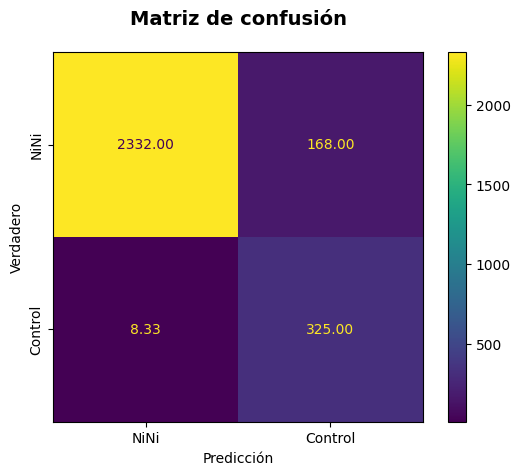

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

fig, ax = plt.subplots()

# Construct confusion matrix from means
cm = np.array([[tn_mean, fp_mean],
                [fn_mean, tp_mean]])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["NiNi", "Control"]
)
disp.plot(ax=ax, cmap='viridis', values_format=".2f")

ax.set_title("Matriz de confusión", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel("Predicción")
ax.set_ylabel("Verdadero")
ax.set_yticklabels(ax.get_yticklabels(), rotation=90, va="center")
plt.show()



In [ ]:
for model_arch in MODEL_ARCHS:
    print(f"Getting results for {model_arch}")
    runs = mlflow.search_runs(
        experiment_ids=[experiment_id],
        output_format="list",
        filter_string=f"params.model_arch = '{model_arch}'",
    )

    if len(runs) != 100:
        print(f"{model_arch} doesn't have 100 runs for experiment {EXPERIMENT_NAME}")


    for run in runs:
        run_data = run.data
        run_params = run_data.params

        precisions.append(float(run_params['cohort_avg_precision']))
        recalls.append(float(run_params['cohort_avg_recall']))
        f1s.append(float(run_params['cohorts_avg_f1']))

        metrics_lists[model_arch] = {
            "precisions": precisions,
            "recalls": recalls,
            "f1s": f1s
        }

In [ ]:
hps = ['hidden_size', 'dropout', 'lr', 'batch_size']
hps_results = {}

for model_arch in MODEL_ARCHS:
    if model_arch == 'psm': continue

    print(f"Getting results for {model_arch}")
    runs = mlflow.search_runs(
        experiment_ids=[experiment_id],
        output_format="list",
        filter_string=f"params.model_arch = '{model_arch}'",
    )

    if len(runs) != 100:
        print(f"{model_arch} doesn't have 100 runs for experiment {EXPERIMENT_NAME}")

    hps_results[model_arch] = {}

    for run in runs:
        run_params = run.data.params
        train_params = ast.literal_eval(run_params['train_params'])

        for hp in hps:
            if hp in train_params:
                value = train_params[hp]

                if hp not in hps_results[model_arch]:
                    hps_results[model_arch][hp] = {}
                if value not in hps_results[model_arch][hp]:
                    hps_results[model_arch][hp][value] = 0

                hps_results[model_arch][hp][value] += 1

print(json.dumps(hps_results, indent=4))

dst_path = os.path.join(GROUP_RESULTS_PATH, 'hyperparams_counts.json')
with open(dst_path, 'w') as f:
    json.dump(hps_results, f, indent=4)